<a href="https://colab.research.google.com/github/frios2020/Project-2/blob/master/NYC_TAXI_FARE_PROJECT_NJIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NYC TAXI FARE PREDICTION PROJECT


NJIT Data Science Program<br>
Course<br>
CS634 Data Mining - Summer 2020<br>

Instructor<br>
Pantelis Monogioudis, Ph.D Professor of Practice, NJIT & Adjunct NYU<br>

Teaching Assistant<br>
Michael Lam (PhD student)<br>

Students:<br>
Fernando Rios<br>
Hassan Ouanir<br>
Ian Kavuma<br>

In [ ]:
from google.colab import files
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# Setup Environment

In [ ]:
# Loading data directly from kaggle
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Move kaggle.json from Google Drive to folder Kaggle
!mkdir -p ~/.kaggle
!cp /content/drive/My\ Drive/kaggle.json  ~/.kaggle/kaggle.json

In [ ]:
# Downloading dataset from Kaggle
!kaggle competitions download -c new-york-city-taxi-fare-prediction

test.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
GCP-Coupons-Instructions.rtf: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# We list all files in the folder where the data was downloaded
print(os.listdir())

['.config', 'drive', '.ipynb_checkpoints', 'GCP-Coupons-Instructions.rtf', 'our_submission.csv', 'test.csv', 'train.csv.zip', 'sample_submission.csv', 'sample_data']


In [ ]:
# Now lets retrive the train dataset from zip to csv, we used the attribut nrows 1_500_000 to bring that number of records 
# to start to study the data
train_df = pd.read_csv('train.csv.zip', compression='zip', nrows=1_500_000)
train_df.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [ ]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


# Data Cleansing and Exploratory Data Analysis (EDA)

## Removing Nulls

In [ ]:
# Counting number of nulls records
print(train_df.isnull().sum())

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    12
dropoff_latitude     12
passenger_count       0
dtype: int64


In [ ]:
# Removing null observations
print('Old size: %d' % len(train_df))
train_df = train_df.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(train_df))

Old size: 1500000
New size: 1499988


## Statistics in General

In [ ]:
# Looking statistics of the features
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.499988e+06,1.499988e+06,1.499988e+06,1.499988e+06,1.499988e+06,1.499988e+06
mean,1.134971e+01,-7.252940e+01,3.993004e+01,-7.252894e+01,3.992976e+01,1.684134e+00
std,9.878688e+00,1.266514e+01,8.063749e+00,1.223703e+01,1.000074e+01,1.318071e+00
min,-6.200000e+01,-3.377681e+03,-3.458665e+03,-3.383297e+03,-3.461541e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073492e+01,-7.399140e+01,4.073401e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075265e+01,-7.398015e+01,4.075315e+01,1.000000e+00
75%,1.250000e+01,-7.396712e+01,4.076711e+01,-7.396368e+01,4.076810e+01,2.000000e+00
max,1.273310e+03,2.522271e+03,2.621628e+03,2.842474e+03,3.345917e+03,2.080000e+02


In the statistics showed above we can notice some things:
* The minimal fare amount is negative.
* Some of the minimum and maximum longitude/lattitude coordinates are way off.
* Minimum passeger count is 0.

We will drop those observations from the dataset.

In [ ]:
# Removing fares <= 2.5 webpage taxi
print('Old size: %d' % len(train_df))
train_df = train_df[(train_df.fare_amount>=2.5)] 
print('New size: %d' % len(train_df))

Old size: 1499988
New size: 1499868


## Boundary trips

In [ ]:
# We calculate the differences longitude and latitude to determine possibles errors in the data.
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

add_travel_vector_features(train_df)

In [ ]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0.002701,0.009041
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,0.036780,0.070701
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,0.008504,0.010708
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,0.004437,0.024949
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,0.011440,0.015754


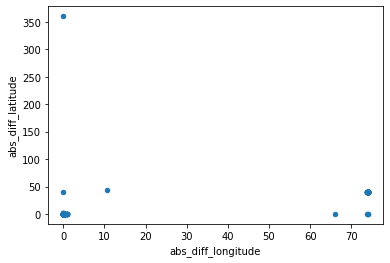

In [ ]:
plot = train_df.iloc[:20000].plot.scatter('abs_diff_longitude', 'abs_diff_latitude')

The graphic showed above tells us that there are many trips with differencies in longitude and latitude greater than 5 degrees = 300 miles. We need to remove them. To do it we create a boundary box of all possibles trips.<br>
Limits of Boundary Box = (-74.311, -72.16, 40.5389, 41.80)<br>

In [ ]:
# This function let us filter all observations into the boundary box.
def select_within_boundingbox(df, BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])
            
# load image of NYC map
BB = (-74.311, -72.16, 40.5389, 41.80)
nyc_map = plt.imread('/content/drive/My Drive/boxdefined.png')

print('Old size: %d' % len(train_df))
train_df = train_df[select_within_boundingbox(train_df, BB)]
print('New size: %d' % len(train_df))

Old size: 1499868
New size: 1468400


In [ ]:
# Verify distances again

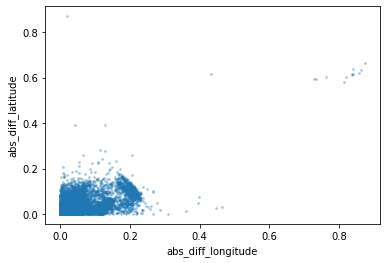

In [ ]:
plot = train_df.iloc[:50000].plot.scatter('abs_diff_longitude', 'abs_diff_latitude',alpha=0.3, s=3)

## Plotting Fares Attributes

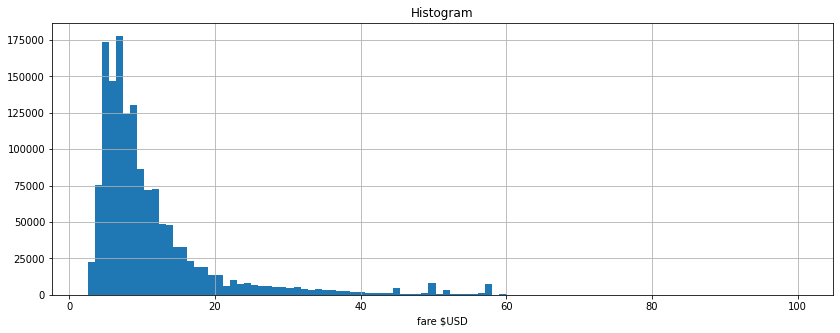

In [ ]:
#Plot histogram of fare <=100
train_df[train_df.fare_amount<=100].fare_amount.hist(bins=100, figsize=(14,5))
plt.xlabel('fare $USD')
plt.title('Histogram');

Clearly, we can notice what the frequencies decrease when the fare increase. Likewise, there are peaks of fare between 40 USD and 60 USD.

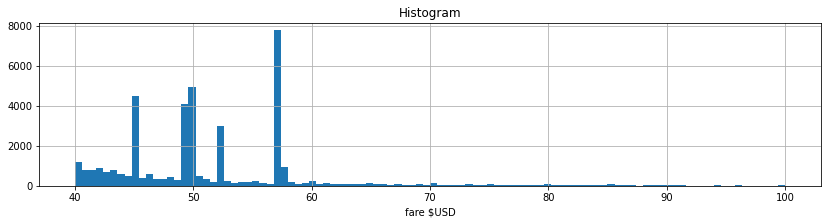

In [ ]:
# Plot fare >=40 and <=100
train_df[(train_df.fare_amount>=40) & (train_df.fare_amount<=100)].fare_amount.hist(bins=100, figsize=(14,3))
plt.xlabel('fare $USD')
plt.title('Histogram');

In the histogram above mentioned there are some small spikes between 40 and 60. This could indicate some fixed fare price (e.g. to/from airports). 

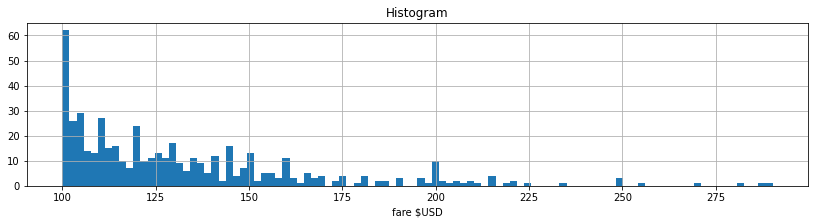

In [ ]:
train_df[(train_df.fare_amount>=100) & (train_df.fare_amount<=300)].fare_amount.hist(bins=100, figsize=(14,3))
plt.xlabel('fare $USD')
plt.title('Histogram');

The graphic above show us how the frequencies continue dropping when the fare increase.

## Plotting pickup and dropoff locations

In [ ]:
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(16,10))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)

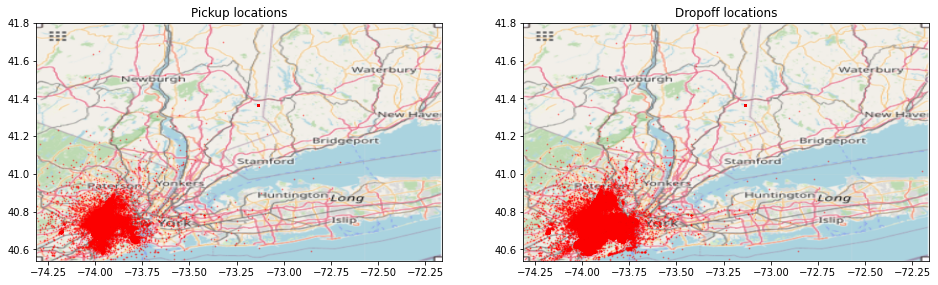

In [ ]:
# plot training data on map
plot_on_map(train_df, BB, nyc_map, s=1, alpha=0.3)

From the training data scatter plot we see that some locations are in the water. Either these are considered as noise, or we drop them from the dataset. We will drop them.

## Removing datapoints on water

In [ ]:
## Removing datapoints on water, this technique requiere a mask of the map, use nyc_mask.png file.
def remove_datapoints_from_water(df):
    def lonlat_to_xy(longitude, latitude, dx, dy, BB):
        return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'), \
               (dy - dy*(latitude - BB[2])/(BB[3]-BB[2])).astype('int')

    # define bounding box
    BB = (-74.311, -72.16, 40.5389, 41.80)
    
    # read nyc mask and turn into boolean map with
    # land = True, water = False
    nyc_mask = plt.imread('/content/drive/My Drive/nyc_mask.png')[:,:,0] > 0.9
    
    # calculate for each lon,lat coordinate the xy coordinate in the mask map
    pickup_x, pickup_y = lonlat_to_xy(df.pickup_longitude, df.pickup_latitude, 
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)
    dropoff_x, dropoff_y = lonlat_to_xy(df.dropoff_longitude, df.dropoff_latitude, 
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)    
    # calculate boolean index
    idx = nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x]
    
    # return only datapoints on land
    return df[idx]

In [ ]:
print('Old size: %d' % len(train_df))
train_df = remove_datapoints_from_water(train_df)
print('New size: %d' % len(train_df))

Old size: 1468400
New size: 1467225


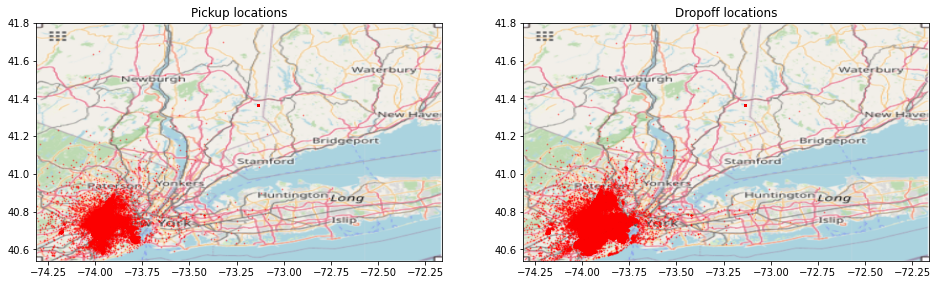

In [ ]:
# plot training data on map to verify datapoints.
plot_on_map(train_df, BB, nyc_map, s=1, alpha=0.3)

## Passenger Count Feature 

In [ ]:
# We describe the feature 'passenger_count' to analize it.
train_df['passenger_count'].describe()

count    1.467225e+06
mean     1.684192e+00
std      1.307070e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      9.000000e+00
Name: passenger_count, dtype: float64

We can clearly see some outlier here as for passenger column the maximum passenger count is 208, minimum is 0

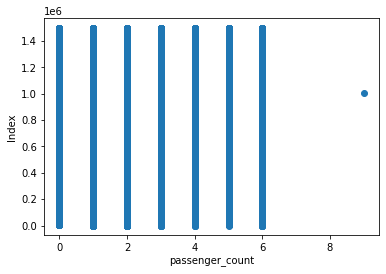

In [ ]:
plt.scatter(x=train_df.passenger_count,y=train_df.index)
plt.ylabel('Index')
plt.xlabel('passenger_count')
plt.show()

In [ ]:
print(train_df.shape)
train_df=train_df[(train_df['passenger_count']>0) & (train_df['passenger_count']<=6)]
print(train_df.shape)

(1467225, 10)
(1461985, 10)


We had to drop passenger counts less than 1 and more than 6.

# Feature Engineering

## Datetime Feature

---



We convert to datetime format the attribute 'pickup_datetime' which is object type.

In [ ]:
train_fe = train_df.copy()
train_fe['pickup_datetime'] = pd.to_datetime(train_fe['pickup_datetime'],infer_datetime_format=True)

In [ ]:
train_fe.dtypes

key                           object
fare_amount                  float64
pickup_datetime       datetime64[ns]
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
passenger_count                int64
abs_diff_longitude           float64
abs_diff_latitude            float64
dtype: object

We create new features, we splitting datetime feature into year/month/day/hour/min

In [ ]:
train_fe['year'] = train_fe['pickup_datetime'].dt.year
train_fe['Month'] = train_fe['pickup_datetime'].dt.month
train_fe['Date'] = train_fe['pickup_datetime'].dt.day
train_fe['Day of Week'] = train_fe['pickup_datetime'].dt.dayofweek
train_fe['Hour'] = train_fe['pickup_datetime'].dt.hour
train_fe['Minute'] = train_fe['pickup_datetime'].dt.minute

We remove unnecesary features 'pickup_datetime', 'key'

In [ ]:
train_final = train_fe.drop(['pickup_datetime', 'key'], axis=1)
train_final

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,year,Month,Date,Day of Week,Hour,Minute
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,0.036780,0.070701,2010,1,5,1,16,52
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,0.008504,0.010708,2011,8,18,3,0,35
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,0.004437,0.024949,2012,4,21,5,4,30
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,0.011440,0.015754,2010,3,9,1,7,51
5,12.1,-74.000964,40.731630,-73.972892,40.758233,1,0.028072,0.026603,2011,1,6,3,9,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1499995,3.7,-73.980903,40.772269,-73.970987,40.768356,1,0.009916,0.003913,2010,5,12,2,19,13
1499996,7.7,-73.997235,40.733465,-73.979808,40.753267,1,0.017427,0.019802,2012,3,15,3,20,19
1499997,15.0,-73.977625,40.753390,-73.983332,40.716782,1,0.005707,0.036608,2013,3,2,5,11,2
1499998,5.0,-73.980613,40.748130,-73.988662,40.751245,1,0.008049,0.003115,2014,6,9,0,11,53


Does date and time have effect on fare?


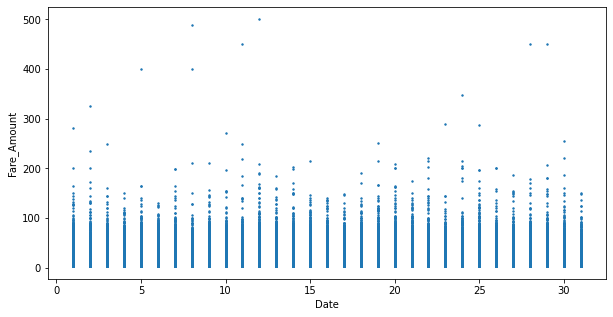

In [ ]:
plt.figure(figsize = (10, 5))
plt.scatter(x= train_final['Date'], y = train_final['fare_amount'], s=2)
plt.xlabel('Date')
plt.ylabel('Fare_Amount')
plt.show()

Text(0, 0.5, 'Frequency')

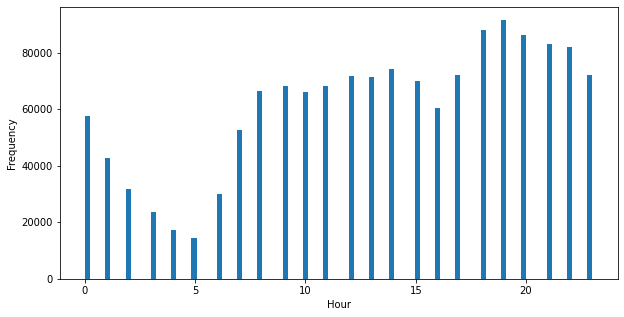

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(train_final['Hour'], bins=100)
plt.xlabel('Hour')
plt.ylabel('Frequency')

Text(0, 0.5, 'Fare')

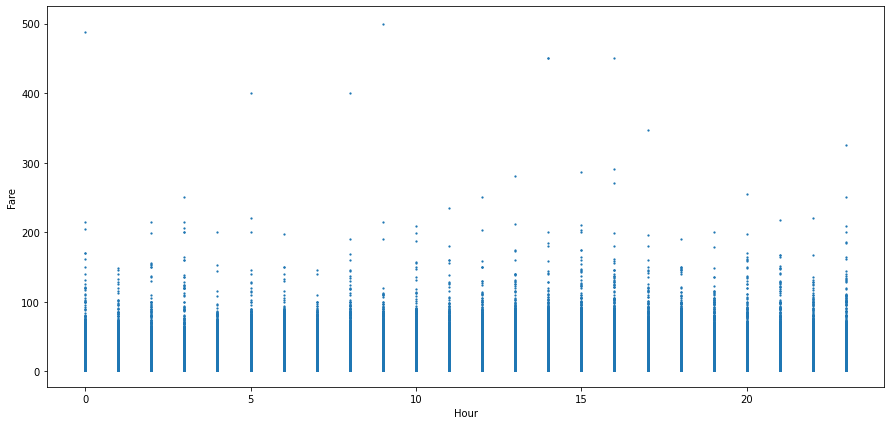

In [ ]:
plt.figure(figsize=(15,7))
plt.scatter(x=train_final['Hour'], y=train_final['fare_amount'], s=1.5)
plt.xlabel('Hour')
plt.ylabel('Fare')

Does the number of passengers effect the fare?

Text(0, 0.5, 'Frequency')

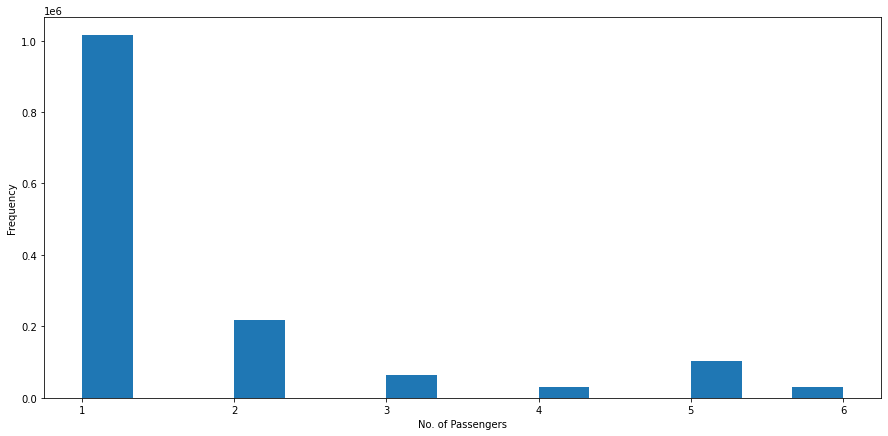

In [ ]:

plt.figure(figsize=(15,7))
plt.hist(train_final['passenger_count'], bins=15)
plt.xlabel('No. of Passengers')
plt.ylabel('Frequency')

## Airports

(-74.2, -73.75)

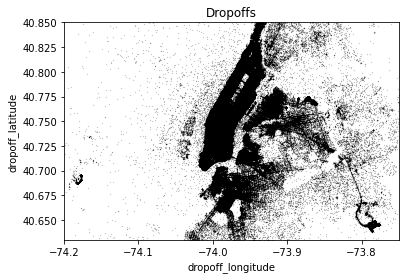

In [ ]:
# We plot heatmap of Pickups and Dropoffs within NYC 
city_long_border = (-74.2, -73.75)
city_lat_border = (40.63, 40.85)

train_final.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude',
                color='black', 
                s=.02, alpha=.6)
plt.title("Dropoffs")
plt.ylim(city_lat_border)
plt.xlim(city_long_border)


(-74.2, -73.75)

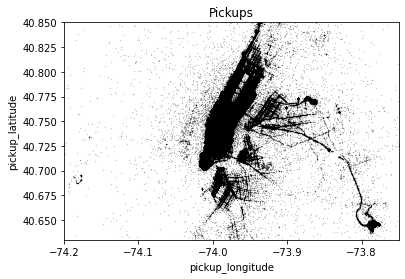

In [ ]:
train_final.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',
                color='black', 
                s=.02, alpha=.6)
plt.title("Pickups")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

Apart from Manhattan, we can see heavy pickups and dropoffs near JFK, La Guardia and Newark Airport.
Then, we will identify trips from/to airports

## Distances

In [ ]:
# We calculate trip distance in miles
def distance(lat1, lat2, lon1,lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

In [ ]:
# we create trip_distance feature
train_final['trip_distance'] = distance(train_final.pickup_latitude, train_final.dropoff_latitude, \
                                     train_final.pickup_longitude, train_final.dropoff_longitude)

count    1.461985e+06
mean     2.065291e+00
std      2.338971e+00
min      0.000000e+00
25%      7.791436e-01
50%      1.336756e+00
75%      2.429825e+00
max      6.886848e+01
Name: trip_distance, dtype: float64

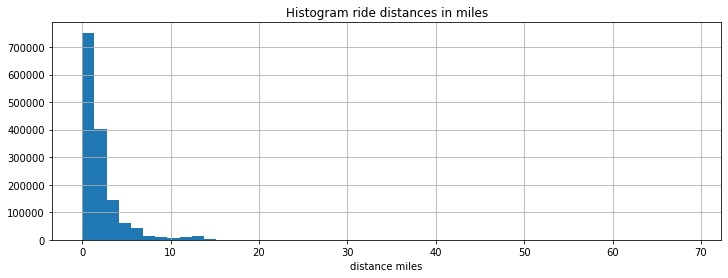

In [ ]:
train_final.trip_distance.hist(bins=50, figsize=(12,4))
plt.xlabel('distance miles')
plt.title('Histogram ride distances in miles')
train_final.trip_distance.describe()

It seems that most rides are just short rides, with a small peak at ~13 miles. This peak could be due to airport drives.

We calculate the average fare by mile

In [ ]:
print("Average $USD/Mile : {:0.2f}".format(train_final.fare_amount.sum()/train_final.trip_distance.sum()))

Average $USD/Mile : 5.48


Plot Distance vs Fare

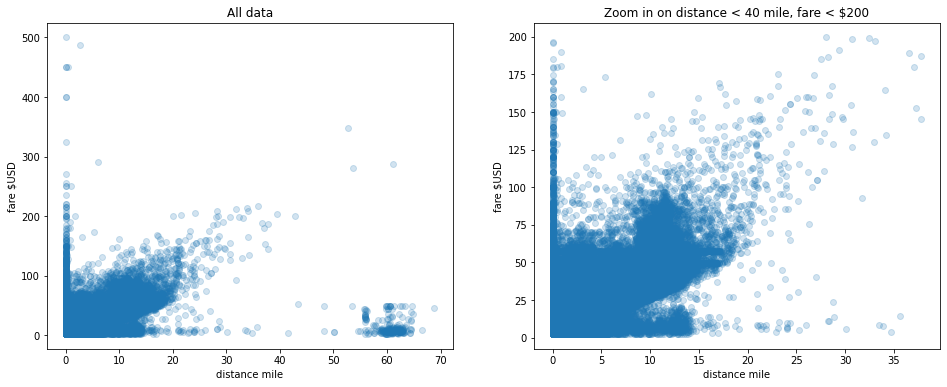

In [ ]:
# scatter plot distance - fare
fig, axs = plt.subplots(1, 2, figsize=(16,6))
axs[0].scatter(train_final.trip_distance, train_final.fare_amount, alpha=0.2)
axs[0].set_xlabel('distance mile')
axs[0].set_ylabel('fare $USD')
axs[0].set_title('All data')

# zoom in on part of data
idx = (train_final.trip_distance < 40) & (train_final.fare_amount < 200)
axs[1].scatter(train_final[idx].trip_distance, train_final[idx].fare_amount, alpha=0.2)
axs[1].set_xlabel('distance mile')
axs[1].set_ylabel('fare $USD')
axs[1].set_title('Zoom in on distance < 40 mile, fare < $200');

We found a strong correlation between distance and fare.

In [ ]:
# remove datapoints with distance <0.05 miles
idx = (train_final.trip_distance >= 0.05)
print('Old size: %d' % len(train_final))
train_final = train_final[idx]
print('New size: %d' % len(train_final))

Old size: 1461985
New size: 1438588


We show the columns of our final train dataset before modeling.

In [ ]:
train_final.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'abs_diff_longitude', 'abs_diff_latitude', 'year', 'Month', 'Date',
       'Day of Week', 'Hour', 'Minute', 'trip_distance'],
      dtype='object')

# Preparing Test Dataset

In [ ]:
test_df = pd.read_csv('test.csv')

In [ ]:
test_df.columns

Index(['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [ ]:
#We create the same features in test dataset like in train dataset.

#Create two features, differences of latitudes and longitudes
add_travel_vector_features(test_df)
# Converted data type 
test_df['pickup_datetime'] = pd.to_datetime(test_df['pickup_datetime'],infer_datetime_format=True)
# we created new features
test_df['year'] = test_df['pickup_datetime'].dt.year
test_df['Month'] = test_df['pickup_datetime'].dt.month
test_df['Date'] = test_df['pickup_datetime'].dt.day
test_df['Day of Week'] = test_df['pickup_datetime'].dt.dayofweek
test_df['Hour'] = test_df['pickup_datetime'].dt.hour
test_df['Minute'] = test_df['pickup_datetime'].dt.minute
# we created trip_distance feature
test_df['trip_distance'] = distance(test_df.pickup_latitude, test_df.dropoff_latitude, \
                                     test_df.pickup_longitude, test_df.dropoff_longitude)

In [ ]:
test_final = test_df.drop(['pickup_datetime'],axis=1)
test_final

,key,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,year,Month,Date,Day of Week,Hour,Minute,trip_distance
0,2015-01-27 13:08:24.0000002,-73.973320,40.763805,-73.981430,40.743835,1,0.008110,0.019970,2015,1,27,1,13,8,1.443607
1,2015-01-27 13:08:24.0000003,-73.986862,40.719383,-73.998886,40.739201,1,0.012024,0.019817,2015,1,27,1,13,8,1.507044
2,2011-10-08 11:53:44.0000002,-73.982524,40.751260,-73.979654,40.746139,1,0.002870,0.005121,2011,10,8,5,11,53,0.384398
3,2012-12-01 21:12:12.0000002,-73.981160,40.767807,-73.990448,40.751635,1,0.009288,0.016172,2012,12,1,5,21,12,1.218529
4,2012-12-01 21:12:12.0000003,-73.966046,40.789775,-73.988565,40.744427,1,0.022519,0.045348,2012,12,1,5,21,12,3.347514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9909,2015-05-10 12:37:51.0000002,-73.968124,40.796997,-73.955643,40.780388,6,0.012482,0.016609,2015,5,10,6,12,37,1.320336
9910,2015-01-12 17:05:51.0000001,-73.945511,40.803600,-73.960213,40.776371,6,0.014702,0.027229,2015,1,12,0,17,5,2.032486
9911,2015-04-19 20:44:15.0000001,-73.991600,40.726608,-73.789742,40.647011,6,0.201859,0.079597,2015,4,19,6,20,44,11.920349
9912,2015-01-31 01:05:19.0000005,-73.985573,40.735432,-73.939178,40.801731,6,0.046394,0.066299,2015,1,31,5,1,5,5.184402


In [ ]:
test_final.columns

Index(['key', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'abs_diff_longitude',
       'abs_diff_latitude', 'year', 'Month', 'Date', 'Day of Week', 'Hour',
       'Minute', 'trip_distance'],
      dtype='object')

# Modeling 

## Features and Labels

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
X = train_final.drop(['fare_amount'],axis=1)
y = train_final['fare_amount']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25,random_state=123)
#test_size is the proportion of data that is to be kept aside for validation


## Baseline Model

A baseline is a solution without applying any machine algorithm techniques.

In [ ]:
average_fare = round(np.mean(y_train),3) #we get the fare mean and we rounded it with three decimals.
baseline_pred=np.repeat(average_fare,y_test.shape[0])
baseline_rmse = np.sqrt(mean_squared_error(baseline_pred,y_test))
print("Basline RMSE: ",baseline_rmse)

Basline RMSE:  9.426247993412444


The Baseline Model resulted in an RMSE of 9.42, So we hope to build a model with RMSE lower than 9.42

## Linear Regression Model

## Building the Model

In this step, we include our final dataset after feature enginnering. To understand and evaluate de models, we will use the following ML algorithms:

*   Linear Regression
*   Random Forest
*   Light GBM












### Linear Regression

This algorithm let us to find a line that best fits the data.

In [ ]:
lm = LinearRegression()
lm.fit(X_train,y_train)
y_pred = np.round(lm.predict(X_test),2)
lm_rmse = np.sqrt(mean_squared_error(y_pred,y_test))
lm_train_rmse=np.sqrt(mean_squared_error(lm.predict(X_train),y_train))
lm_variance=abs(lm_train_rmse-lm_rmse)
print("Test RMSE for LR is: ",lm_rmse)
print("Train RMSE for LR is: ",lm_train_rmse)
print("Variance for LR is:",lm_variance)

Test RMSE for LR is:  4.4835402489758005
Train RMSE for LR is:  4.561216421314959
Variance for LR is: 0.07767617233915836


The Test RMSE for Linear Regression is 4.48, and the training RMSE is 4.56. This model clearly improved our baseline prediction.Let's try a model more complex "Random Forest".

### Random Forest

In [ ]:
#We hope this model can fit the data better. Let's see.
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, criterion='mse',random_state=883, n_jobs=-1, max_depth=4)
rf.fit(X_train,y_train)
rf_pred=rf.predict(X_test)
rf_rmse=np.sqrt(mean_squared_error(rf_pred,y_test))
print("RMSE for Random Forest in test dataset : ",rf_rmse)
rf_pred1=rf.predict(X_train)
rf_rmse1=np.sqrt(mean_squared_error(rf_pred1,y_train))
print("RMSE for Random Forest in Train dataset : ",rf_rmse1)
lm_variance=abs(rf_rmse-rf_rmse1)
print("Variance for LR is:",lm_variance)

RMSE for Random Forest in test dataset :  4.0412868697498485
RMSE for Random Forest in Train dataset :  4.005620864181149
Variance for LR is: 0.035666005568699255


Random Forest Regressor has a error rate clearly lower than Linear Regression, the test RMSE for Linear Regression was 4.48 while for Random Forest is 4.04 . Now, Let's try with LightGBM. It is a algorithm based in boosting tree. Light GBM grows leaf-wise instead of level-wise. Light GBM is fast, takes less RAM to run.

### LightGBM

In [ ]:
import lightgbm as lgb
params = {'learning_rate':0.75, 'application':'regression','max_depth':3,'num_leaves':100,'verbosity':-1,'metric':'RMSE',}
train_set = lgb.Dataset(X_train,y_train,silent=True)
lb = lgb.train(params,train_set = train_set,num_boost_round=300)
y_pred=lb.predict(X_test,num_iteration=lb.best_iteration)
y_pred1=lb.predict(X_train,num_iteration=lb.best_iteration)
lb_rmse=np.sqrt(mean_squared_error(y_test,y_pred))
lb_rmse1=np.sqrt(mean_squared_error(y_train,y_pred1))
lm_variance=abs(lb_rmse-lb_rmse1)
print("RMSE Test dataset: ",lb_rmse)
print("RMSE Train dataset: ",lb_rmse1)
print("Variance for LR is:",lm_variance)


RMSE Test dataset:  3.2675645754536093
RMSE Train dataset:  3.1678155039308495
Variance for LR is: 0.0997490715227598


In [ ]:
# AMAZING LightGBM model got a error rate lower than Forest Regression 3.26 on test dataset


<table style="align:left">
<tr>
<th>Model Name</th><th>Test RMSE</th><th>Train RMSE</th><th>Variance</th>
</tr>
<tr>
<td>Linear Regression</td><td>4.4835</td><td>4.5612</td><td>0.0777</td>
</tr>
<tr>
<td>Random Forest</td><td>4.0412</td><td>4.0056</td><td>0.0357</td>
</tr>
<tr>
<td>Light GBM</td><td>3.2676</td><td>3.1678</td><td>0.0997</td>
</tr>
</table>

In [ ]:
#Light GBM has a error rate lower than the others models.

#Submission

In [ ]:
# We get the list of columns to train the model.
wanted_columns = X_train.columns
# We predict on test dataset
predictions=lb.predict(test_final[wanted_columns],num_iteration=lb.best_iteration)

In [ ]:
# We show some predictions
predictions[:20]

array([10.0800934 , 10.56100766,  4.56849293,  9.36310038, 15.42365308,
       10.67617736,  5.4797058 , 49.92111545, 11.58645265,  7.27113223,
       10.64112219, 17.5619997 ,  3.89657829,  6.55934149,  7.66863178,
       10.13912956,  4.5176802 ,  9.14218944,  4.75119434,  4.32264738])

In [ ]:
# Create a submission dataframe, we add key and predictions columns
submission = pd.DataFrame()
submission['key']=test_final['key']
submission['fare_amount']=predictions
submission.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.080093
1,2015-01-27 13:08:24.0000003,10.561008
2,2011-10-08 11:53:44.0000002,4.568493
3,2012-12-01 21:12:12.0000002,9.363100
4,2012-12-01 21:12:12.0000003,15.423653


In [ ]:
# Convert DataFrame to CSV File for Kaggle
submission.to_csv('our_submission.csv',index=False)

In [ ]:
# Now we are ready to submit our submission in Kaggle.